In [ ]:
from drive.MyDrive.datas.module.preprocess import *
from drive.MyDrive.datas.module.setting_tf import *
from drive.MyDrive.datas.module.visualization import *

In [ ]:
dataset = get_dataset()
print(dataset.shape)
dataset.head(2)

(10051, 3)


,image_path,status,where
0,/content/Dataset/train/photos/ecdf0c64ec3f284a...,photos,train
1,/content/Dataset/train/photos/f1f7ffeca29f43de...,photos,train


In [ ]:
datas = split_train_valid_df(dataset=dataset, img_size=224, shuffle=True)

/content/drive/MyDrive/datas/module/preprocess.py:68: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  datas['train_df'] = np.array(datas['train_df'])
/content/drive/MyDrive/datas/module/preprocess.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  datas['valid_df'] = np.array(datas['valid_df'])


In [ ]:
print(f'Shape >> train_dataframe :{datas["train_df"].shape} \n\t valiation_dataframe :{datas["valid_df"].shape}')

Shape >> train_dataframe :(7041, 2) 
	 valiation_dataframe :(3010, 2)


In [ ]:
X_train, y_train, X_valid, y_valid = split_X_y_dataset(datas=datas)

In [ ]:
print(f"Shape >> X_train :{X_train.shape}, y_train :{y_train.shape} \n\t X_valid :{X_valid.shape}, y_valid :{y_valid.shape}")

Shape >> X_train :(7041, 224, 224, 3), y_train :(7041,) 
	 X_valid :(3010, 224, 224, 3), y_valid :(3010,)


In [ ]:
# MinMaxScaling
X_train = X_train / 255.0
X_valid = X_valid / 255.0

In [ ]:
import tensorflow as tf

In [ ]:
train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
valid = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))

In [ ]:
datas, X_train, y_train, X_valid, y_valid = None, None, None, None, None

train_batches = train.shuffle(len(train)).batch(32)
valid_batches = valid.shuffle(len(valid)).batch(32)

In [ ]:
# for image_batch, label_batch in train_batches.take(1):
#   pass

# image_batch.shape

TensorShape([32, 224, 224, 3])

In [ ]:
base_model = load_base_model("mobilenet", input_shape=(224, 224, 3), trainable=False)

In [ ]:
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 128)               163968    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 16)                1040      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 2,431,265
Trainable params: 173,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
monitor_ls = ["val_accuracy", "val_loss"]
callbacks = setting_callback("mobile", monitors=monitor_ls, min_delta=0.0001, acc_patience=10, loss_patience=7)

In [ ]:
history = model.fit(train_batches, epochs=150, validation_data=valid_batches, verbose=1,
                    callbacks=callbacks)

Epoch 1/150
221/221 [==============================] - 45s 94ms/step - loss: 0.4835 - accuracy: 0.7718 - val_loss: 0.3448 - val_accuracy: 0.8568

Epoch 00001: val_accuracy improved from -inf to 0.85681, saving model to /content/drive/MyDrive/datas/model_result/mobile_acc.h5

Epoch 00001: val_loss improved from inf to 0.34484, saving model to /content/drive/MyDrive/datas/model_result/mobile_loss.h5
Epoch 2/150
221/221 [==============================] - 25s 88ms/step - loss: 0.3326 - accuracy: 0.8598 - val_loss: 0.3049 - val_accuracy: 0.8781

Epoch 00002: val_accuracy improved from 0.85681 to 0.87807, saving model to /content/drive/MyDrive/datas/model_result/mobile_acc.h5

Epoch 00002: val_loss improved from 0.34484 to 0.30488, saving model to /content/drive/MyDrive/datas/model_result/mobile_loss.h5
Epoch 3/150
221/221 [==============================] - 27s 88ms/step - loss: 0.2919 - accuracy: 0.8803 - val_loss: 0.2897 - val_accuracy: 0.8837

Epoch 00003: val_accuracy improved from 0.878

In [ ]:
max_acc_idx = np.argmax(history.history['val_accuracy'])
print(f'MAX Acc model >> Acc :{history.history["val_accuracy"][max_acc_idx]}, Loss :{history.history["val_loss"][max_acc_idx]}')

min_loss_idx = np.argmin(history.history['val_loss'])
print(f'MIN Loss model >> Acc :{history.history["val_accuracy"][min_loss_idx]}, Loss :{history.history["val_loss"][min_loss_idx]}')

MAX Acc model >> Acc :0.89435213804245, Loss :0.27653154730796814
MIN Loss model >> Acc :0.8933554887771606, Loss :0.2691862881183624


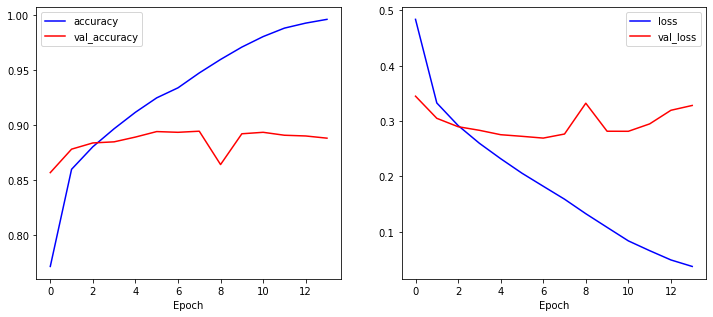

In [ ]:
make_scores_graph(history=history)

In [ ]:
model.load_weights("/content/drive/MyDrive/datas/model_result/moblie_loss.h5")

In [ ]:
for valid_batch, label_batch in valid_batches.take(1):
  pass

valid_batch.shape

TensorShape([32, 224, 224, 3])

In [ ]:
predictions = model.predict(valid_batch)
predictions = predictions.squeeze(-1)
predictions

array([[5.1215058e-03],
       [9.9705517e-01],
       [1.2546879e-01],
       [9.8734957e-01],
       [8.5688680e-01],
       [8.5765845e-01],
       [6.1629415e-01],
       [3.0605828e-03],
       [3.2363150e-02],
       [9.9505782e-01],
       [1.6102133e-02],
       [7.9823444e-03],
       [3.2800990e-03],
       [7.1763415e-03],
       [1.1518641e-03],
       [7.1954668e-02],
       [7.5915885e-01],
       [8.7983358e-01],
       [4.6210873e-01],
       [6.7213685e-03],
       [1.9175960e-01],
       [1.2886229e-01],
       [3.1451613e-01],
       [7.2725588e-03],
       [3.2865706e-01],
       [5.4951072e-02],
       [2.5989911e-01],
       [4.3210188e-01],
       [3.8493264e-01],
       [3.3312786e-04],
       [9.9616063e-01],
       [1.2680000e-01]], dtype=float32)

In [ ]:
def classify(x):
  result = 1 if x >= 0.5 else 0
  
  return result

In [ ]:
label_batch

<tf.Tensor: shape=(32,), dtype=int64, numpy=
array([0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       1, 0, 1, 0, 0, 1, 1, 0, 1, 0])>

In [ ]:
pred_label = [classify(data) for data in predictions]
print(pred_label)

[0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]


In [ ]:
label_batch.numpy()

array([0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       1, 0, 1, 0, 0, 1, 1, 0, 1, 0])

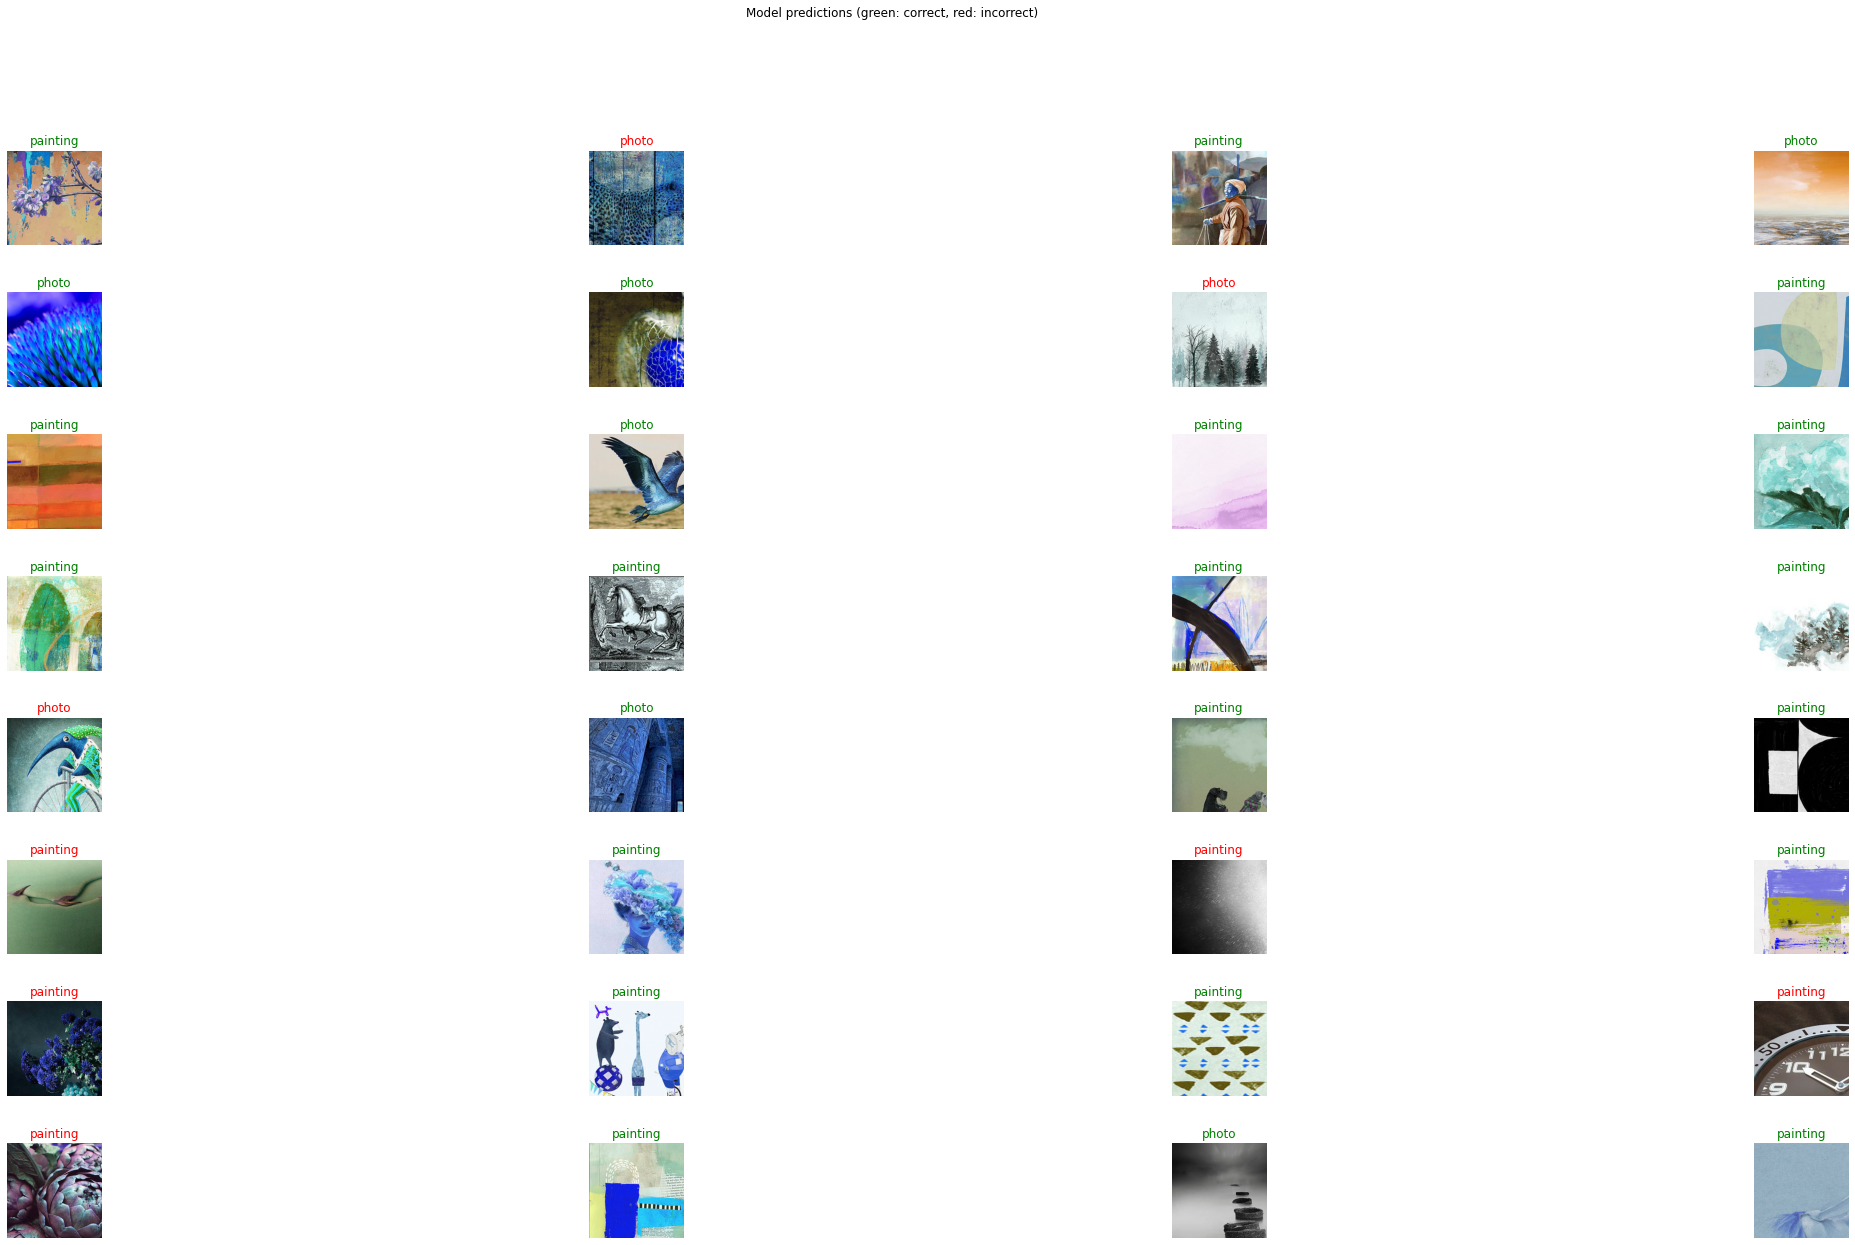

In [ ]:
plt.figure(figsize=(40, 20))
plt.subplots_adjust(hspace=0.5)
for n in range(32):
  plt.subplot(8, 4, n+1)
  plt.imshow(valid_batch[n])
  color = "green" if pred_label[n] == label_batch.numpy()[n] else "red"
  title = "photo" if pred_label[n] == 1 else "painting"
  plt.title(title, color=color)
  plt.axis('off')

_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")